In [81]:
import osmnx as ox
import random
import heapq

In [118]:
place_name = "Buenos Aires, Argentina" # Manhattan, NY - Provincia de Santiago - Las Condes, Santiago, Chile
G = ox.graph_from_place(place_name, network_type='drive')

In [119]:
for edge in G.edges:
    # Cleaning the "maxspeed" attribute, some values are lists, some are strings, some are None
    maxspeed = 40  # Default speed
    if "maxspeed" in G.edges[edge]:
        maxspeed_value = G.edges[edge]["maxspeed"]
        if isinstance(maxspeed_value, list):
            speeds = [int(speed) for speed in maxspeed_value if speed.isdigit()]
            maxspeed = min(speeds) if speeds else maxspeed  # Use default if no valid speeds found
        elif isinstance(maxspeed_value, str):
            maxspeed = int(maxspeed_value) if maxspeed_value.isdigit() else maxspeed  # Use default if not a digit
    G.edges[edge]["maxspeed"] = maxspeed
    # Adding the "weight" attribute (time = distance / speed)
    G.edges[edge]["weight"] = G.edges[edge]["length"] / maxspeed

In [132]:
def style_unvisited_edge(edge):
    G.edges[edge]["color"] = "#2432B0"
    G.edges[edge]["alpha"] = 0.3
    G.edges[edge]["linewidth"] = 0.5

def style_visited_edge(edge):
    G.edges[edge]["color"] = "#2432B0"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_active_edge(edge):
    G.edges[edge]["color"] = '#3F50E7'
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_path_edge(edge):
    G.edges[edge]["color"] = "white"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

In [133]:
def plot_graph():
    ox.plot_graph(
        G,
        node_size =  [ G.nodes[node]["size"] for node in G.nodes ],
        edge_color = [ G.edges[edge]["color"] for edge in G.edges ],
        edge_alpha = [ G.edges[edge]["alpha"] for edge in G.edges ],
        edge_linewidth = [ G.edges[edge]["linewidth"] for edge in G.edges ],
        node_color = "white",
        bgcolor = "#0F1126",
        dpi=300
    )

In [134]:
def plot_heatmap(algorithm):
    edge_colors = ox.plot.get_edge_colors_by_attr(G, f"{algorithm}_uses", cmap="hot")
    fig, _ = ox.plot_graph(
        G,
        node_size = 0,
        edge_color = edge_colors,
        bgcolor = "#18080e",
        dpi=300
    )

In [135]:
def dijkstra(orig, dest, plot=False):
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["distance"] = float("inf")
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["distance"] = 0
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    pq = [(0, orig)]
    step = 0
    while pq:
        _, node = heapq.heappop(pq)
        if node == dest:
            if plot:
                print("Iteraciones:", step)
                plot_graph()
            return
        if G.nodes[node]["visited"]: continue
        G.nodes[node]["visited"] = True
        for edge in G.out_edges(node):
            style_visited_edge((edge[0], edge[1], 0))
            neighbor = edge[1]
            weight = G.edges[(edge[0], edge[1], 0)]["weight"]
            if G.nodes[neighbor]["distance"] > G.nodes[node]["distance"] + weight:
                G.nodes[neighbor]["distance"] = G.nodes[node]["distance"] + weight
                G.nodes[neighbor]["previous"] = node
                heapq.heappush(pq, (G.nodes[neighbor]["distance"], neighbor))
                for edge2 in G.out_edges(neighbor):
                    style_active_edge((edge2[0], edge2[1], 0))
        step += 1

In [136]:
def distance(node1, node2):
    x1, y1 = G.nodes[node1]["x"], G.nodes[node1]["y"]
    x2, y2 = G.nodes[node2]["x"], G.nodes[node2]["y"]
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

def a_star(orig, dest, plot=False):
    for node in G.nodes:
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
        G.nodes[node]["g_score"] = float("inf")
        G.nodes[node]["f_score"] = float("inf")
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    G.nodes[orig]["g_score"] = 0
    G.nodes[orig]["f_score"] = distance(orig, dest)
    pq = [(G.nodes[orig]["f_score"], orig)]
    step = 0
    while pq:
        _, node = heapq.heappop(pq)
        if node == dest:
            if plot:
                print("Iteraciones:", step)
                plot_graph()
            return
        for edge in G.out_edges(node):
            style_visited_edge((edge[0], edge[1], 0))
            neighbor = edge[1]
            tentative_g_score = G.nodes[node]["g_score"] + distance(node, neighbor)
            if tentative_g_score < G.nodes[neighbor]["g_score"]:
                G.nodes[neighbor]["previous"] = node
                G.nodes[neighbor]["g_score"] = tentative_g_score
                G.nodes[neighbor]["f_score"] = tentative_g_score + distance(neighbor, dest)
                heapq.heappush(pq, (G.nodes[neighbor]["f_score"], neighbor))
                for edge2 in G.out_edges(neighbor):
                    style_active_edge((edge2[0], edge2[1], 0))
        step += 1

In [137]:
def reconstruct_path(orig, dest, plot=False, algorithm=None):
    for edge in G.edges:
        style_unvisited_edge(edge)
    dist = 0
    speeds = []
    curr = dest
    while curr != orig:
        if curr in G.nodes:
            prev = G.nodes[curr].get("previous")
            if prev is not None and (prev, curr, 0) in G.edges:  # Check if the edge exists
                dist += G.edges[(prev, curr, 0)]["length"]
                speeds.append(G.edges[(prev, curr, 0)]["maxspeed"])
                style_path_edge((prev, curr, 0))
                # Increment the usage counter for the edge based on the algorithm
                if algorithm == "dijkstra":
                    G.edges[(prev, curr, 0)]["dijkstra_uses"] += 1
                elif algorithm == "a_star":
                    G.edges[(prev, curr, 0)]["a_star_uses"] += 1
            curr = prev  # Update current node to previous one
        else:
            break  # Exit the loop if 'curr' is not in G.nodes
    dist /= 1000
    if plot:
        print(f"Distance: {dist} km")
        print(f"Avg. speed: {sum(speeds)/len(speeds)} km/h")
        print(f"Total time: {dist/(sum(speeds)/len(speeds)) * 60} minutes")
        plot_graph()


In [144]:
start = random.choice(list(G.nodes))
end = random.choice(list(G.nodes))

Iteraciones: 8331


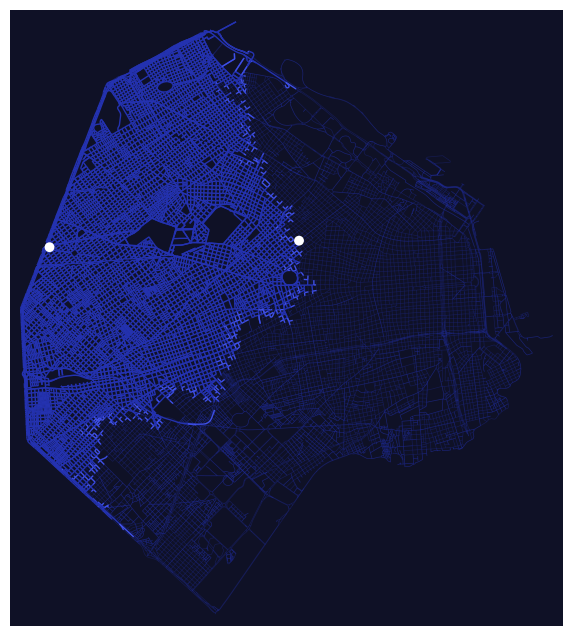

Distance: 9.309941 km
Avg. speed: 55.64356435643565 km/h
Total time: 10.038833177935942 minutes


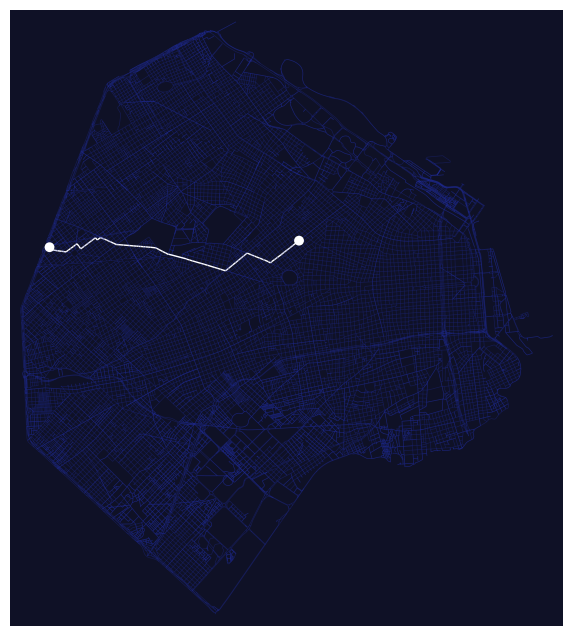

Iteraciones: 1143


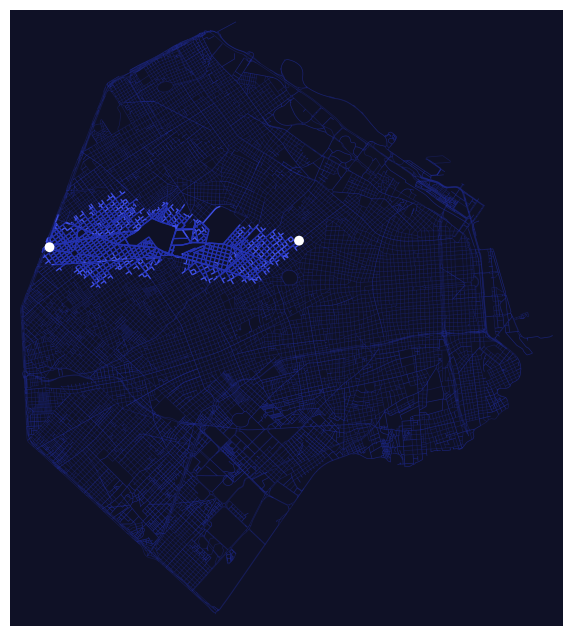

Distance: 8.974105999999997 km
Avg. speed: 50.8421052631579 km/h
Total time: 10.590559875776393 minutes


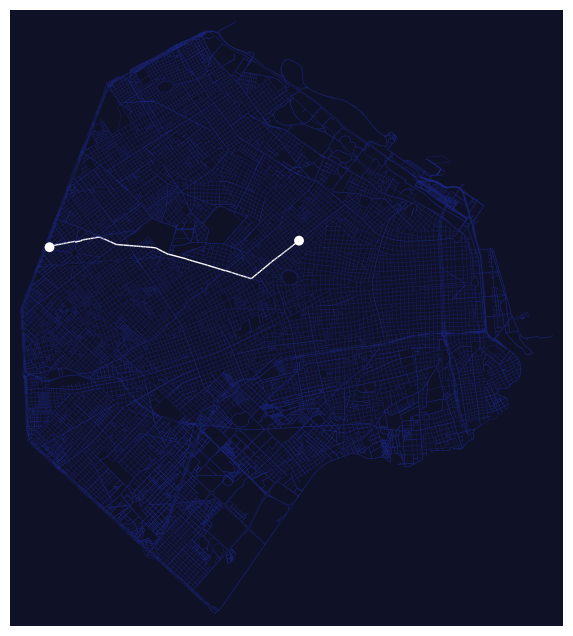

In [145]:
dijkstra(start, end, plot=True)

reconstruct_path(start, end, plot=True)

a_star(start, end, plot=True)

reconstruct_path(start, end, plot=True)

In [146]:
N = 10 # times to run each algorithm
for edge in G.edges:
    G.edges[edge]["dijkstra_uses"] = 0
    G.edges[edge]["a_star_uses"] = 0

In [147]:
for _ in range(N): # (might take a while, depending on N)
    start = random.choice(list(G.nodes))
    end = random.choice(list(G.nodes))
    dijkstra(start, end)
    reconstruct_path(start, end, algorithm="dijkstra")
    a_star(start, end)
    reconstruct_path(start, end, algorithm="a_star")


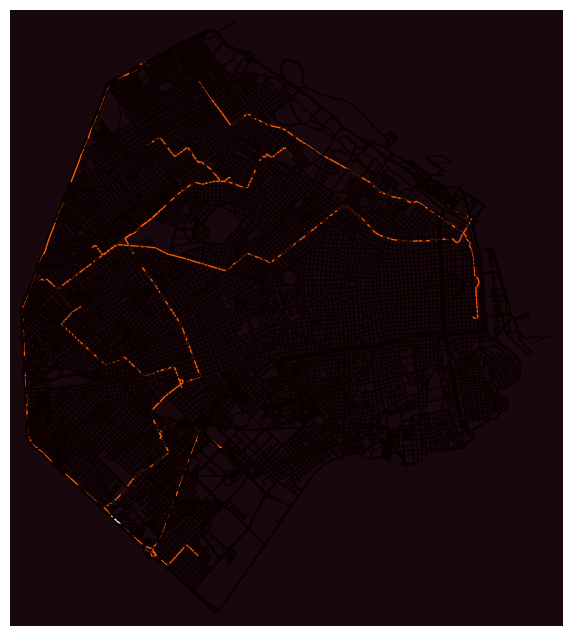

In [148]:
plot_heatmap("dijkstra")

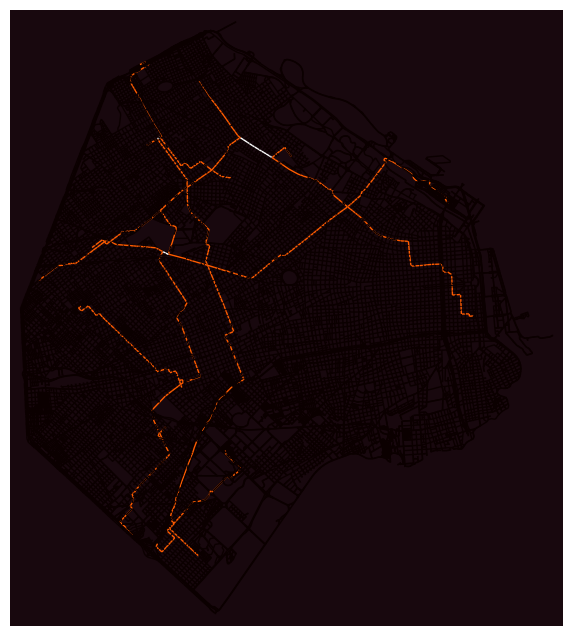

In [149]:
plot_heatmap("a_star")